<a href="https://colab.research.google.com/github/ale8ander/Collect_Survey_Result/blob/main/DS2024_2022428210_LeeJuyeong_imf_global_low_carbon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
pinuto_imf_global_low_carbon_tech_trade_and_impact_path = kagglehub.dataset_download('pinuto/imf-global-low-carbon-tech-trade-and-impact')

print('Data source import complete.')


# DS2024 Term Project
written by Lee Juyeong

## Data Used
Dataset: Data anlaysis with IMF Global Carbon Tech Trade & Impact

## Objective of This Analysis
To explore how Asian countries have contributed to and impacted the global low-carbon technology trade.

## Techniques Used
Visualization: Line chart, Pie chart, Scatter plot<br>
Pre-Processing: Standardization, treating missing values<br>
Feature extraction: LDA<br>
Clustering: K-Means with Elbow method, Hierarchical Agglomerative Clustreing

### 1) import libraris and functions required
### 2) Read dataset from csv file

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/work
ing/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data = pd.read_csv("/kaggle/input/imf-global-low-carbon-tech-trade-and-impact/Trade_in_Low_Carbon_Technology_Products.csv")

/kaggle/input/imf-global-low-carbon-tech-trade-and-impact/Trade_in_Low_Carbon_Technology_Products.geojson
/kaggle/input/imf-global-low-carbon-tech-trade-and-impact/Trade_in_Low_Carbon_Technology_Products.csv


### 3) Data visualization
3-1) Line Chart<br>
To see tendancy of trade voulme of Asian countries.

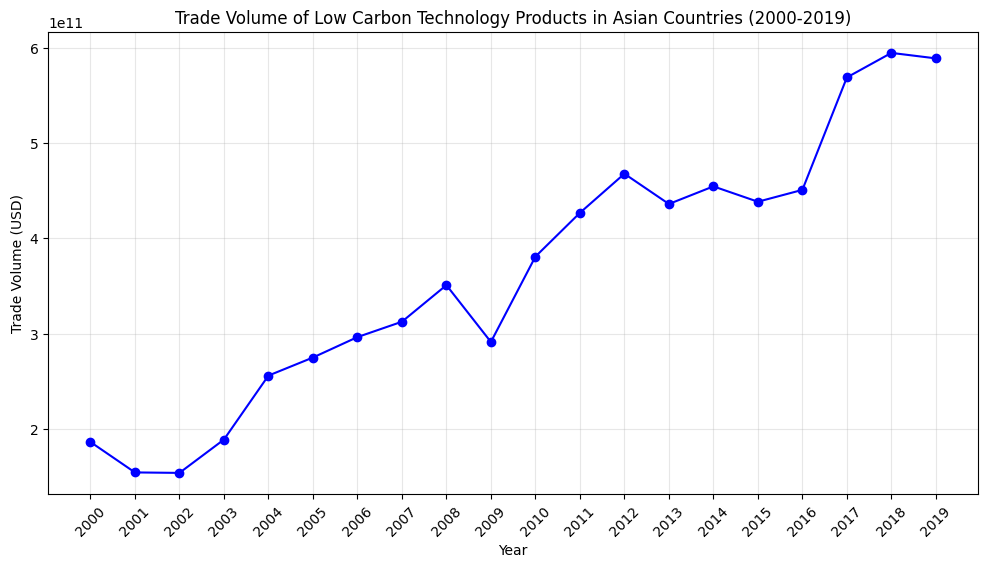

In [ ]:
# Filter Asian countries
asian_countries = [
    'Afghanistan, Islamic Rep. of', 'Bangladesh', 'Bhutan', 'Brunei Darussalam',
    'Cambodia', 'China', 'Cyprus', 'India', 'Indonesia', 'Iraq', 'Israel',
    'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Lebanon', 'Malaysia',
    'Maldives', 'Mongolia', 'Myanmar', 'Nepal', 'Oman', 'Pakistan',
    'Philippines', 'Qatar', 'Saudi Arabia', 'Singapore', 'Sri Lanka',
    'Thailand', 'United Arab Emirates', 'Vietnam'
]
asian_data = data[data['Country'].isin(asian_countries)]

# Aggregate trade data from 2000 to 2019
year_columns = [f'F{year}' for year in range(2000, 2020)]
asian_trade_by_year = asian_data[year_columns].sum()

# Plot the line chart
plt.figure(figsize=(12, 6))
asian_trade_by_year.plot(kind='line', marker='o', color='blue')
plt.title('Trade Volume of Low Carbon Technology Products in Asian Countries (2000-2019)')
plt.xlabel('Year')
plt.ylabel('Trade Volume (USD)')
plt.xticks(ticks=range(len(year_columns)), labels=[str(year) for year in range(2000, 2020)], rotation=45)
plt.grid(alpha=0.3)
plt.show()

In this line chart, we can see:<br>
Generally Trade Voulme is increasing from 2000 to 2019.<br>
The figure increased more than three-fold.<br>
Except for 2009 when Bankruptcy of Lehman Brothers happens.

3-2) Pie chart<br>
To show trade share distribution among Asian countries, with smaller contributions categorized as “Other.”

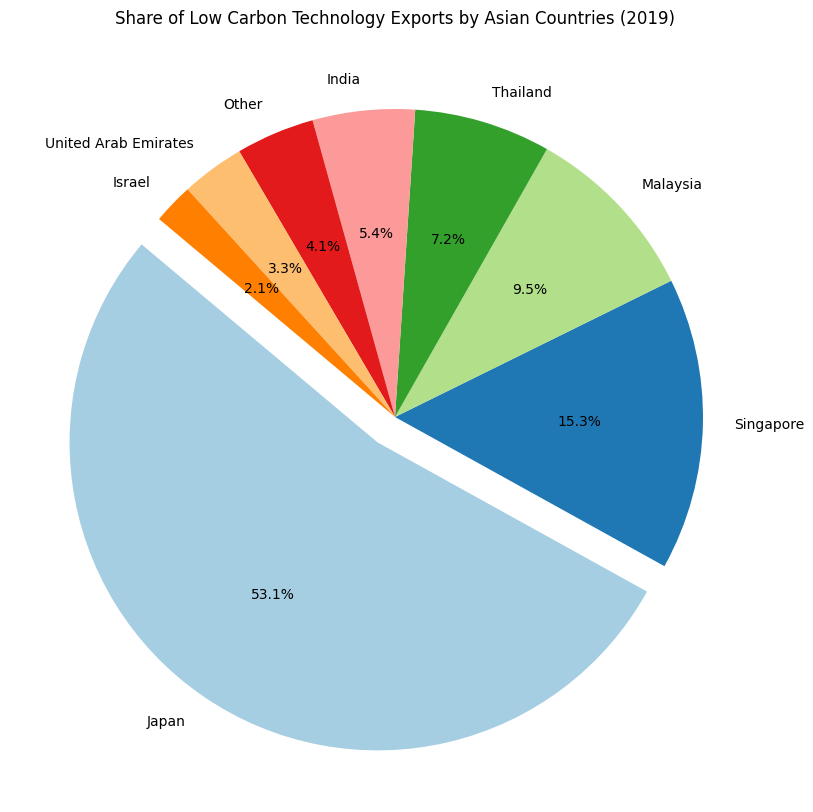

In [ ]:
# Filter for exports indicator and Asian countries
asian_exports = asian_data[asian_data['Indicator'] == 'Exports of low carbon technology products']

# Aggregate data for a specific year (e.g., 2019) by country
asian_exports_2019 = asian_exports.groupby('Country')['F2019'].sum()

# Calculate total exports for normalization
total_exports = asian_exports_2019.sum()

# Categorize countries with less than 2% of the total as "Other"
# Because I judge the figure less then 2% is not meaningful in this analysis
asian_exports_2019 = asian_exports_2019.apply(
    lambda x: x if (x / total_exports) >= 0.02 else 0
)
asian_exports_2019['Other'] = total_exports - asian_exports_2019.sum()
asian_exports_2019 = asian_exports_2019[asian_exports_2019 > 0]  # Remove zero entries

# Customizing the pie chart
colors = plt.cm.Paired(range(len(asian_exports_2019)))
asian_exports_2019.sort_values(ascending=False).plot(
    kind='pie',
    figsize=(10, 10),
    autopct='%1.1f%%',
    startangle=140,
    explode=[0.1 if i == 0 else 0 for i in range(len(asian_exports_2019))],  # Highlight largest
    colors=colors
)
plt.title("Share of Low Carbon Technology Exports by Asian Countries (2019)")
plt.ylabel("")
plt.show()

From this pie chart, we can see:<br>
Japan takes up more than half in low carbon technology exports by Asian countries in 2019.<br>
The Second is Singapore which occupy 15.3%.

3-3) Scatter Plot<br>
To examine relationships between trade metrics over different years.<br>
(I excluded data of Japan, since this data is too outlier compared to other's.)

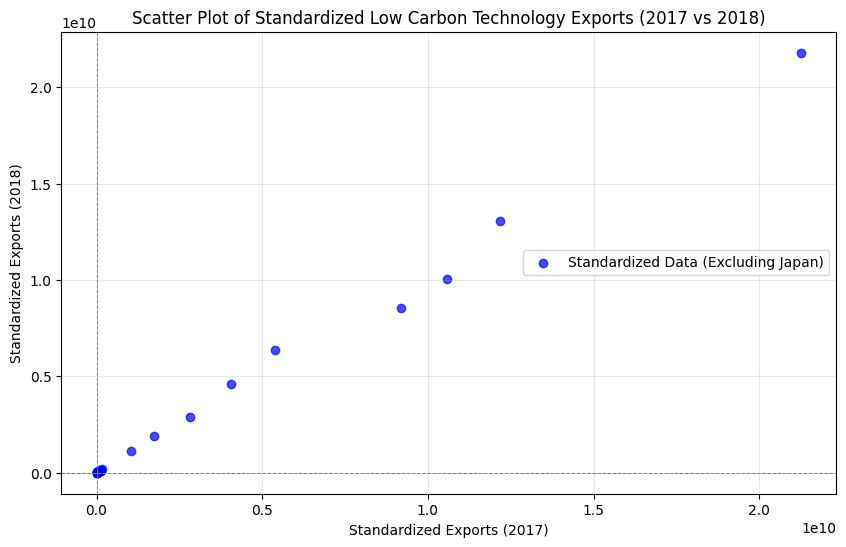

In [ ]:
# Create a copy of the DataFrame to avoid modifying a slice
asian_exports = asian_exports.copy()

# Add Total_Exports column
asian_exports.loc[:, 'Total_Exports'] = asian_exports[['F2017', 'F2018', 'F2019']].sum(axis=1)

# Create the Category column
asian_exports.loc[:, 'Category'] = pd.cut(
    asian_exports['Total_Exports'],
    bins=[-float('inf'), 1e6, 1e7, float('inf')],
    labels=['Low', 'Medium', 'High']
)# Exclude data from Japan
asian_exports_no_japan = asian_exports[asian_exports['Country'] != 'Japan']

# Scatter plot of two features (e.g., F2017 vs F2018)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(
    asian_exports_no_japan['F2017'],
    asian_exports_no_japan['F2018'],
    alpha=0.7,
    c='blue',
    label='Standardized Data (Excluding Japan)'
)
plt.title('Scatter Plot of Standardized Low Carbon Technology Exports (2017 vs 2018)')
plt.xlabel('Standardized Exports (2017)')
plt.ylabel('Standardized Exports (2018)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

From this scatter plot, we can see:<br>
It shows positive correlation, which means countries with high export volumes in 2018 also had high export volumes in 2018.<br>
Points in the upper right coner represent countries with high export voulums in both 2017 and 2018, indicating that they play a leading role.

### 4) Pre-Processing - Standardization & treaing missing values
Standardized features (F2017, F2018, F2019) to ensure uniform scaling for analysis<br>
And also treating missing values, if not it results serious problem in following analysis

In [ ]:
# Create a new 'Category' column based on total exports
asian_exports['Total_Exports'] = asian_exports[['F2017', 'F2018', 'F2019']].sum(axis=1)

# Categorize countries into 'Low', 'Medium', and 'High' based on Total_Exports
asian_exports['Category'] = pd.cut(
    asian_exports['Total_Exports'],
    bins=[-float('inf'), 1e6, 1e7, float('inf')],
    labels=['Low', 'Medium', 'High']
)

# Drop rows with missing values in the numeric columns
asian_exports = asian_exports.dropna(subset=['F2017', 'F2018', 'F2019']).copy()

# Select numeric columns for clustering
numeric_columns = ['F2017', 'F2018', 'F2019']
asian_exports.loc[:, numeric_columns] = asian_exports[numeric_columns].fillna(asian_exports[numeric_columns].mean())

X = asian_exports[numeric_columns]
y = asian_exports['Category']

# Handle missing values
X = X.fillna(X.mean())

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 5) Feature Extraction - LDA   
Reduced dimensionality to 2 components while preserving class separability<br>
Used to visualize and analyze trade patterns across categories (Low, Medium, High trade impact)

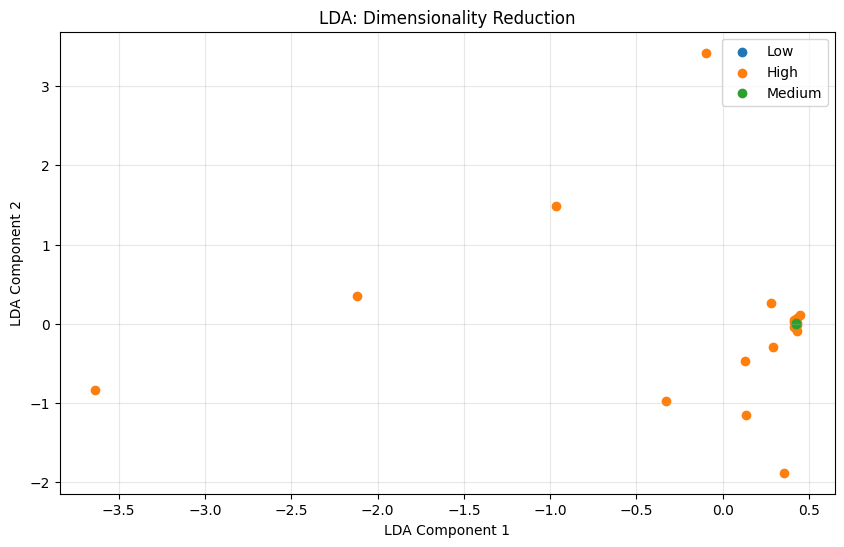

In [ ]:
# Apply LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_scaled, y)

# Visualize LDA results
plt.figure(figsize=(10, 6))
for category in y.unique():
    plt.scatter(
        X_lda[y == category, 0],
        X_lda[y == category, 1],
        label=category
    )
plt.title('LDA: Dimensionality Reduction')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

From this LDA results, we can see:<br>
high export impact dominates.<br>
medium and high figure overlap, so we need to imporve classification.

### 6) Clustering
6-1) K-means Clustering with Elbow Method<br>
Grouped countries into clusters based on trade metrics<br>
Used the Elbow Method to determine the optimal number of clusters(k)

In class, I learned determining optimal k-value impacts performance of K-means clustering.<br>
So I apply this method in this anaysis.

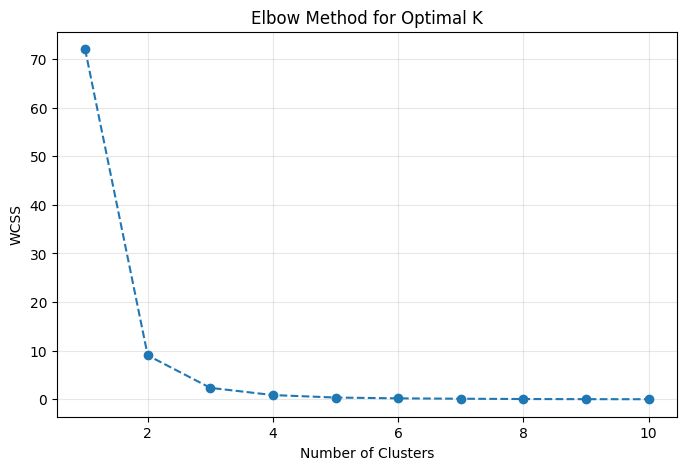

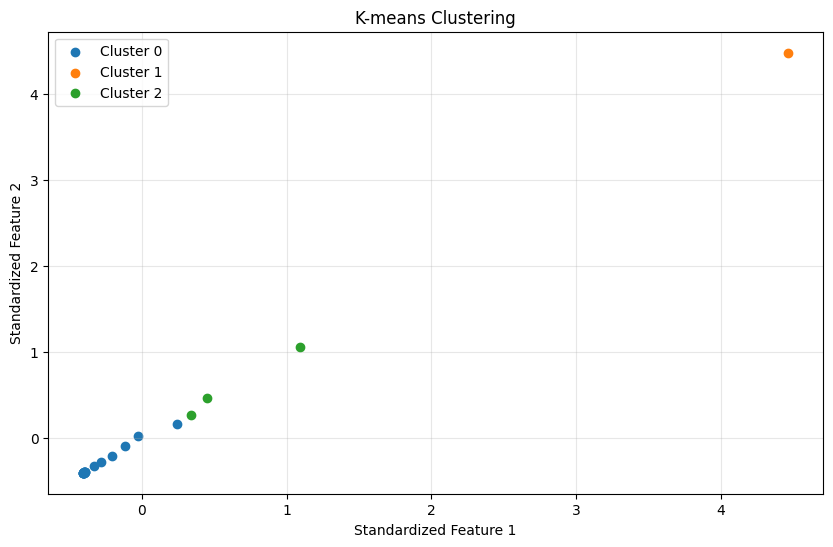

                F2017         F2018         F2019
Cluster                                          
0        1.247145e+09  1.309651e+09  1.037576e+09
1        6.925254e+10  7.304070e+10  7.425879e+10
2        1.466393e+10  1.496834e+10  1.492748e+10


In [ ]:
# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Find the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS to find the "elbow"
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(alpha=0.3)
plt.show()

# Perform K-means clustering
optimal_clusters = 3
# Replace with the value from the Elbow Method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
asian_exports['Cluster'] = kmeans.fit_predict(X_scaled)

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
for cluster in range(optimal_clusters):
    plt.scatter(
        X_scaled[asian_exports['Cluster'] == cluster, 0],
        X_scaled[asian_exports['Cluster'] == cluster, 1],
        label=f'Cluster {cluster}'
    )
plt.title('K-means Clustering')
plt.xlabel('Standardized Feature 1')
plt.ylabel('Standardized Feature 2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

cluster_summary = asian_exports.groupby('Cluster')[numeric_columns].mean()
print(cluster_summary)

From this K-means clustering graph, we can see:<br>
Cluster 0(blue): contries with low volumes<br>
Cluster 1(Orange): contries with high voulmes, expecting it is Japan.<br>
Cluster 2(Green): contries with medium voulmes<br>

6-2) Hierarachical Agglomerative Clustering<br>
	Visualized relationships between countries using a dendrogram<br>
	Grouped similar countries into clusters based on linkage distances

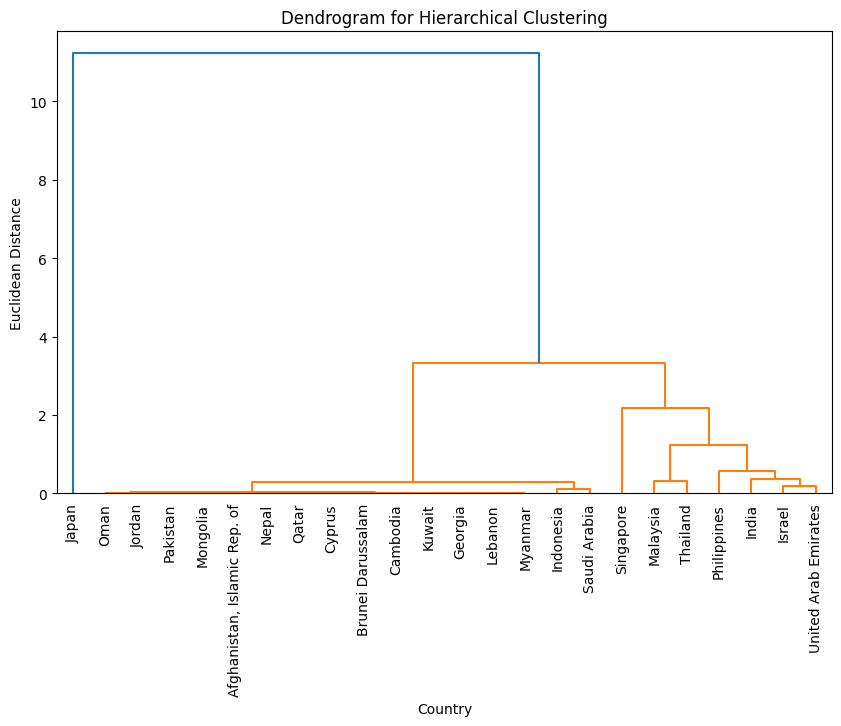

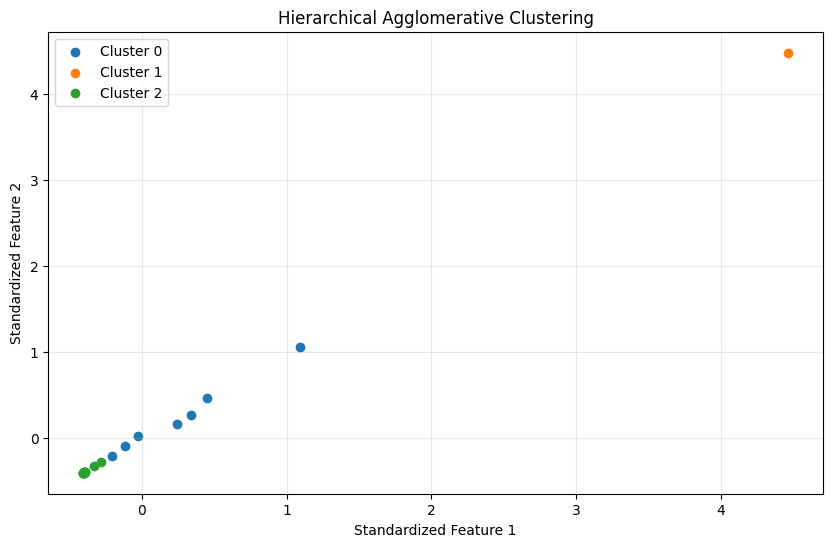

                F2017         F2018         F2019
Cluster                                          
0        9.347007e+09  9.616341e+09  8.900173e+09
1        6.925254e+10  7.304070e+10  7.425879e+10
2        2.191033e+08  2.364789e+08  2.020462e+08


In [ ]:
# Generate the linkage matrix
linkage_matrix = sch.linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
sch.dendrogram(linkage_matrix, labels=asian_exports['Country'].values, leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Country')
plt.ylabel('Euclidean Distance')
plt.show()

# Choose the number of clusters (e.g., 3)
num_clusters = 3

# Fit Agglomerative Clustering
hac = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')
asian_exports['Cluster'] = hac.fit_predict(X_scaled)

# Scatter plot for two features
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    plt.scatter(
        X_scaled[asian_exports['Cluster'] == cluster, 0],
        X_scaled[asian_exports['Cluster'] == cluster, 1],
        label=f'Cluster {cluster}'
    )
plt.title('Hierarchical Agglomerative Clustering')
plt.xlabel('Standardized Feature 1')
plt.ylabel('Standardized Feature 2')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Summarize clusters
cluster_summary = asian_exports.groupby('Cluster')[numeric_columns].mean()
print(cluster_summary)

From this hierarchical agglomerative clustering graph and Dendogram, we can see:<br>
Cluster 0 (Blue): contries with low volumes (e.g., Nepal, Qatar)  <br>
Cluster 1(Orange): contries with high volumes (e.g., Japan)<br>
Cluster 2(Green): contries with low volumes (e.g., India, Thailand, Malaysia)<br>